In [51]:
%pip install squarify

In [52]:
import requests, pandas as pd, time
import seaborn as sns
import matplotlib.pyplot as plt
import squarify as sq

In [53]:


# 1️⃣ Get all African countries via the /country endpoint
COUNTRIES_URL = "https://api.worldbank.org/v2/country?region=AFR&format=json&per_page=400"
country_resp  = requests.get(COUNTRIES_URL).json()
# The second element (index 1) is the list of country dicts
all_african = country_resp[1]

# Extract ISO3 codes (and drop the aggregate “SSA” entry if present)
iso3_codes = [c["id"] for c in all_african if c["id"] != "SSA"]
print(f"Found {len(iso3_codes)} ISO3 codes: {iso3_codes[:5]} …")

# 2️⃣ Pull GDP data for each country, 2015–2024
YEARS     = "2015:2024"
INDICATOR = "NY.GDP.MKTP.CD"  # GDP (current US$)
records   = []

for iso3 in iso3_codes:
    url = (
        f"https://api.worldbank.org/v2/country/{iso3}/indicator/"
        f"{INDICATOR}?format=json&date={YEARS}&per_page=60"
    )
    resp = requests.get(url).json()
    # resp[1] holds the yearly entries (might be empty)
    if len(resp) < 2 or not resp[1]:
        continue
    for entry in resp[1]:
        records.append({
            "country": entry["country"]["value"],
            "iso3":    iso3,
            "year":    int(entry["date"]),
            "gdp_usd": entry["value"],
        })
    time.sleep(0.2)

# 3️⃣ Build DataFrame
df = pd.DataFrame(records)
df.sort_values(["country","year"], inplace=True)
print(df.head())
print(df.tail())
print(f"Total rows: {len(df):,}")

# 4️⃣ Save to CSV
#df.to_csv("africa_gdp_2015_2024.csv", index=False)
print("Saved → africa_gdp_2015_2024.csv")


Found 54 ISO3 codes: ['AGO', 'BDI', 'BEN', 'BFA', 'BWA'] …
     country iso3  year       gdp_usd
139  Algeria  DZA  2015  1.874939e+11
138  Algeria  DZA  2016  1.807638e+11
137  Algeria  DZA  2017  1.898809e+11
136  Algeria  DZA  2018  1.945545e+11
135  Algeria  DZA  2019  1.934597e+11
      country iso3  year       gdp_usd
534  Zimbabwe  ZWE  2020  2.686794e+10
533  Zimbabwe  ZWE  2021  2.724052e+10
532  Zimbabwe  ZWE  2022  3.278975e+10
531  Zimbabwe  ZWE  2023  3.523137e+10
530  Zimbabwe  ZWE  2024           NaN
Total rows: 540
Saved → africa_gdp_2015_2024.csv


In [54]:
#df.to_csv("africa_gdp_2015_2024.csv", index=False)

In [55]:
#Display the dataframe for inspection
df.head(10)

,country,iso3,year,gdp_usd
139,Algeria,DZA,2015,1.874939e+11
138,Algeria,DZA,2016,1.807638e+11
137,Algeria,DZA,2017,1.898809e+11
136,Algeria,DZA,2018,1.945545e+11
135,Algeria,DZA,2019,1.934597e+11
134,Algeria,DZA,2020,1.648734e+11
133,Algeria,DZA,2021,1.862312e+11
132,Algeria,DZA,2022,2.256385e+11
131,Algeria,DZA,2023,2.476262e+11
130,Algeria,DZA,2024,NaN


In [56]:
# Cleaning the data
# Drop empty rows
df_clean = df.dropna(subset=['gdp_usd'])

# 2 convert gdp_usd to numeric column
pd.to_numeric(df_clean['gdp_usd'])

#romove country with less than 5 years data
min_years = 5
country_counts = df_clean["country"].value_counts()
valid_countries = country_counts[country_counts >= min_years].index
df_clean = df_clean[df_clean["country"].isin(valid_countries)]


In [57]:
# check the datatype
df_clean.dtypes

country     object
iso3        object
year         int64
gdp_usd    float64
dtype: object

In [58]:
# Check the dataframe
df_clean.head(10)

,country,iso3,year,gdp_usd
139,Algeria,DZA,2015,1.874939e+11
138,Algeria,DZA,2016,1.807638e+11
137,Algeria,DZA,2017,1.898809e+11
136,Algeria,DZA,2018,1.945545e+11
135,Algeria,DZA,2019,1.934597e+11
134,Algeria,DZA,2020,1.648734e+11
133,Algeria,DZA,2021,1.862312e+11
132,Algeria,DZA,2022,2.256385e+11
131,Algeria,DZA,2023,2.476262e+11
9,Angola,AGO,2015,9.049642e+10


In [59]:
# pivot table for exploration
pivot = df_clean.pivot(index='year', columns='country', values='gdp_usd')
pivot.head(10)

country,Algeria,Angola,Benin,Botswana,Burkina Faso,Burundi,Cabo Verde,Cameroon,Central African Republic,Chad,...,Sierra Leone,Somalia,South Africa,Sudan,Tanzania,Togo,Tunisia,Uganda,Zambia,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
2015,1.874939e+11,9.049642e+10,1.138816e+10,1.353075e+10,1.183216e+10,3.104004e+09,1.749858e+09,3.221023e+10,1.695826e+09,1.095039e+10,...,6.651627e+09,6.152149e+09,3.467098e+11,5.172676e+10,4.741392e+10,5.755461e+09,4.577949e+10,3.238718e+10,2.125122e+10,1.996312e+10
2016,1.807638e+11,5.276162e+10,1.182107e+10,1.508264e+10,1.283336e+10,2.644488e+09,1.849790e+09,3.381434e+10,1.825018e+09,1.009778e+10,...,6.042616e+09,6.613743e+09,3.235855e+11,4.263038e+10,4.977441e+10,6.071171e+09,4.436007e+10,2.920399e+10,2.095841e+10,2.054868e+10
2017,1.898809e+11,7.369015e+10,1.270166e+10,1.610516e+10,1.410696e+10,2.723587e+09,1.996742e+09,3.609855e+10,2.072350e+09,1.000039e+10,...,5.818480e+09,7.621502e+09,3.814488e+11,4.128362e+10,5.327488e+10,6.387423e+09,4.216353e+10,3.074447e+10,2.587360e+10,5.107466e+10
2018,1.945545e+11,7.945069e+10,1.426241e+10,1.703194e+10,1.589007e+10,2.667182e+09,2.205100e+09,3.995555e+10,2.220979e+09,1.123917e+10,...,6.390515e+09,7.873441e+09,4.052607e+11,3.233378e+10,5.700371e+10,7.029300e+09,4.268650e+10,3.292703e+10,2.631151e+10,3.415607e+10
2019,1.934597e+11,7.089796e+10,1.439169e+10,1.672591e+10,1.603281e+10,2.576519e+09,2.252177e+09,3.966776e+10,2.221301e+09,1.131495e+10,...,6.523578e+09,8.655024e+09,3.893300e+11,3.233808e+10,6.102673e+10,6.992700e+09,4.190564e+10,3.534816e+10,2.330867e+10,2.571741e+10
2020,1.648734e+11,4.850156e+10,1.565155e+10,1.496029e+10,1.772501e+10,2.649680e+09,1.821566e+09,4.077324e+10,2.326721e+09,1.071540e+10,...,6.688595e+09,8.628394e+09,3.379747e+11,2.703459e+10,6.606874e+10,7.400284e+09,4.249178e+10,3.760037e+10,1.813776e+10,2.686794e+10
2021,1.862312e+11,6.650513e+10,1.769008e+10,1.875095e+10,1.969752e+10,2.775799e+09,2.051843e+09,4.501194e+10,2.516498e+09,1.177998e+10,...,7.165214e+09,9.483997e+09,4.208869e+11,3.422951e+10,7.065563e+10,8.342244e+09,4.681229e+10,4.052979e+10,2.209642e+10,2.724052e+10
2022,2.256385e+11,1.043997e+11,1.740175e+10,2.032196e+10,1.882022e+10,3.338723e+09,2.247003e+09,4.434721e+10,2.382619e+09,1.239681e+10,...,7.119137e+09,1.020277e+10,4.069200e+11,5.166688e+10,7.576997e+10,8.169476e+09,4.457976e+10,4.556533e+10,2.916378e+10,3.278975e+10
2023,2.476262e+11,8.482465e+10,1.967605e+10,1.939608e+10,2.032462e+10,2.642162e+09,2.533819e+09,4.927941e+10,2.555492e+09,1.314933e+10,...,6.411870e+09,1.096852e+10,3.806993e+11,1.092655e+11,7.906240e+10,9.171262e+09,4.852960e+10,4.876896e+10,2.757796e+10,3.523137e+10


In [60]:
# Save the cleaned data 
df_clean.to_csv('gdp_data_2014-2023_cleaned.csv', index=False)

In [125]:
# Calculate the average gdp of all countries and group by country to get the top 5 countries
top5_avg_gdp = (
    df_clean.groupby('country')['gdp_usd']
    .mean(numeric_only= True)
    .sort_values(ascending=False)
    .head(5)
)

print("Top 5 African countries by average GDP (2015–2023):\n")
top5_avg_gdp

# Save their names for future filtering
top5_countries = top5_avg_gdp.index.tolist()
print("\nTop 5 countries:", top5_countries)

Top 5 African countries by average GDP (2015–2023):


Top 5 countries: ['nigeria', 'south africa', 'egypt, arab rep.', 'algeria', 'morocco']


In [62]:
top5_avg_gdp.head()

country
Nigeria             4.315512e+11
South Africa        3.769795e+11
Egypt, Arab Rep.    3.525198e+11
Algeria             1.967247e+11
Morocco             1.261704e+11
Name: gdp_usd, dtype: float64

## Line plot for top 5 countries 

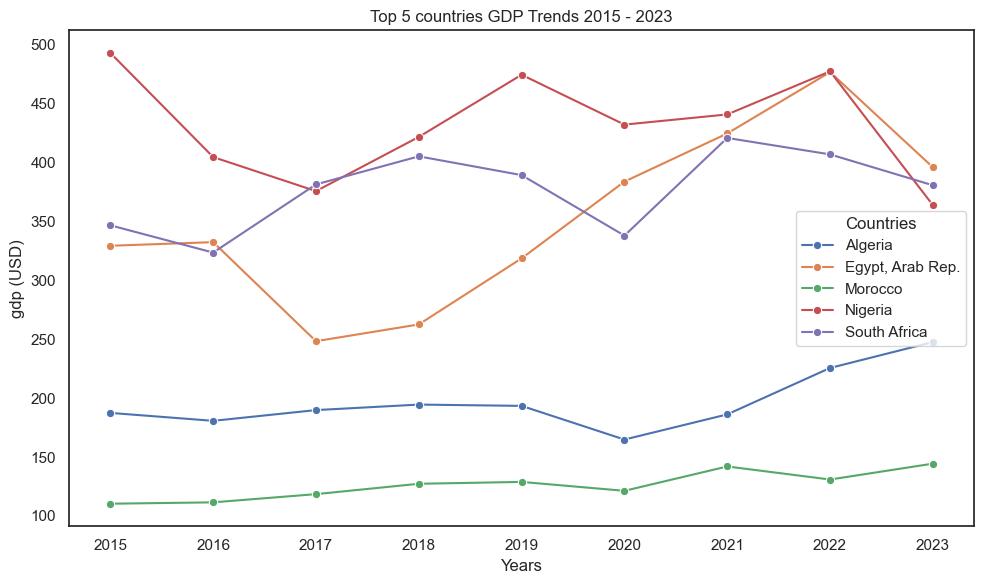

In [88]:
#Set style to use for the plot 
sns.set(style='white')

# set figure size
plt.figure(figsize=(10,6))

#Filter top 5 from the dataframe
df_top5 = df_clean[df_clean['country'].isin(top5_countries)].copy()

#create another column to display the numbers for the gdp in billions
df_top5['gdp_usd_billions'] = df_top5['gdp_usd'] /1e9

#plot
sns.lineplot(data=df_top5, x='year', y='gdp_usd_billions', hue='country', marker='o')

plt.title('Top 5 countries GDP Trends 2015 - 2023')
plt.xlabel('Years')
plt.ylabel('gdp (USD)')
plt.tight_layout()
plt.legend(title= 'Countries')
plt.grid(False)
plt.show()


## BAR CHART (MOST RECENT YEAR GDP)

In [64]:
# filter by only 2023
df_2023 = df_top5[df_top5['year'] == 2023]

# sort values of 2023 from highest to lowest
df_2023_sorted = df_2023.sort_values('gdp_usd_billions', ascending= False)

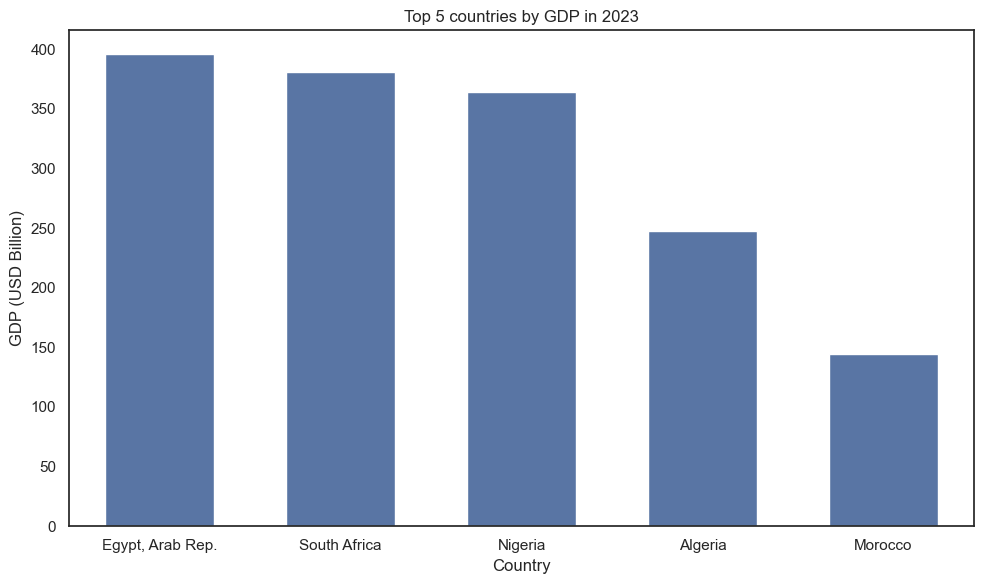

In [85]:
# Bar chart
sns.set(style='white')
width = 0.6

plt.figure(figsize=(10,6))

sns.barplot(data=df_2023_sorted, x='country', y='gdp_usd_billions', width=width,  color='b')

plt.title('Top 5 countries by GDP in 2023')
plt.xlabel('Country')
plt.ylabel('GDP (USD Billion)')
plt.tight_layout()
plt.show()


## AREA PLOT (cummulative GDP progress)

<Figure size 1000x600 with 0 Axes>

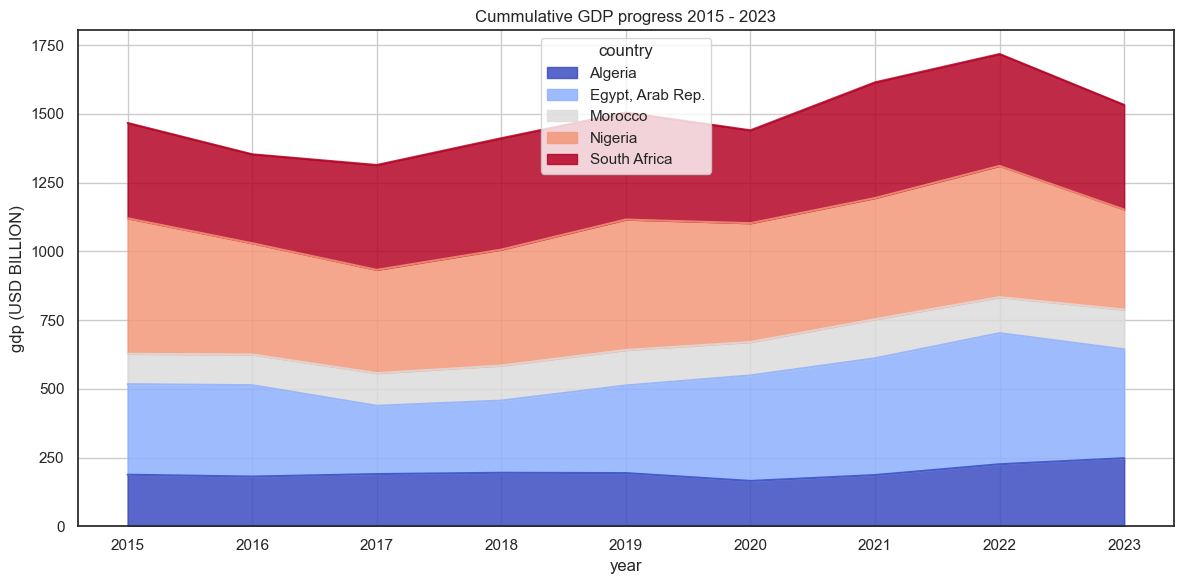

In [130]:
# pivot for stacked colum chart
area_df = df_top5.pivot(index='year', columns='country', values='gdp_usd_billions')

plt.figure(figsize=(10,6))

area_df.plot(kind='area', figsize=(12, 6), cmap='coolwarm', alpha= 0.85)

plt.title('Cummulative GDP progress 2015 - 2023')
plt.xlabel('year')
plt.ylabel('gdp (USD BILLION)')
plt.legend(title= 'country')
plt.tight_layout()
plt.grid(True)
plt.show()


## HEATMAP (GDP intensity over time)

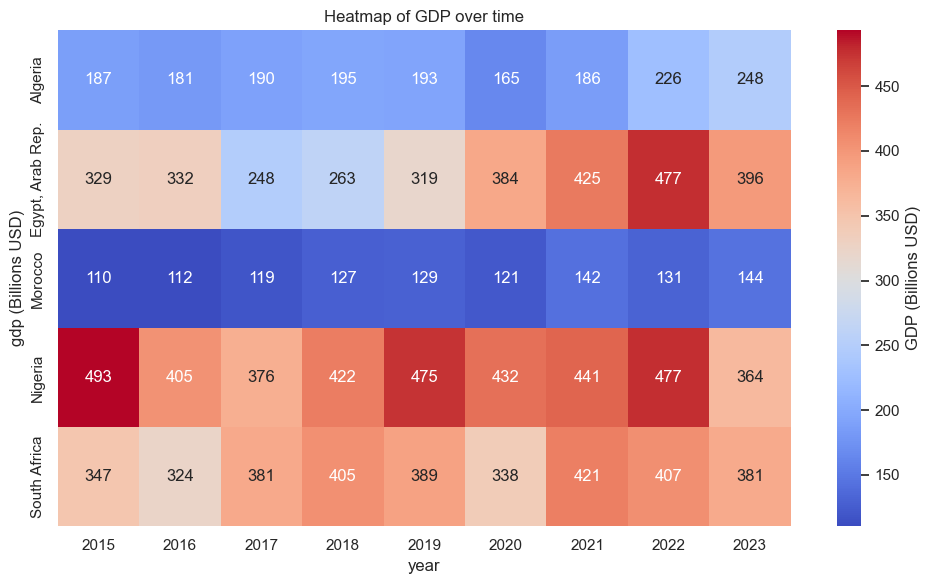

In [122]:
# normalise for better contrast
heatmap_df = area_df.copy()
heatmap_df = heatmap_df.T

plt.figure(figsize=(10,6))

sns.heatmap(heatmap_df, annot=True, fmt='.0f', cmap='coolwarm', cbar_kws={'label': 'GDP (Billions USD)'})
plt.title('Heatmap of GDP over time')
plt.xlabel('year')
plt.ylabel('gdp (Billions USD)')
plt.tight_layout()
plt.show()


## Boxplot: GDP Distribution (Variation Over 10 Years)

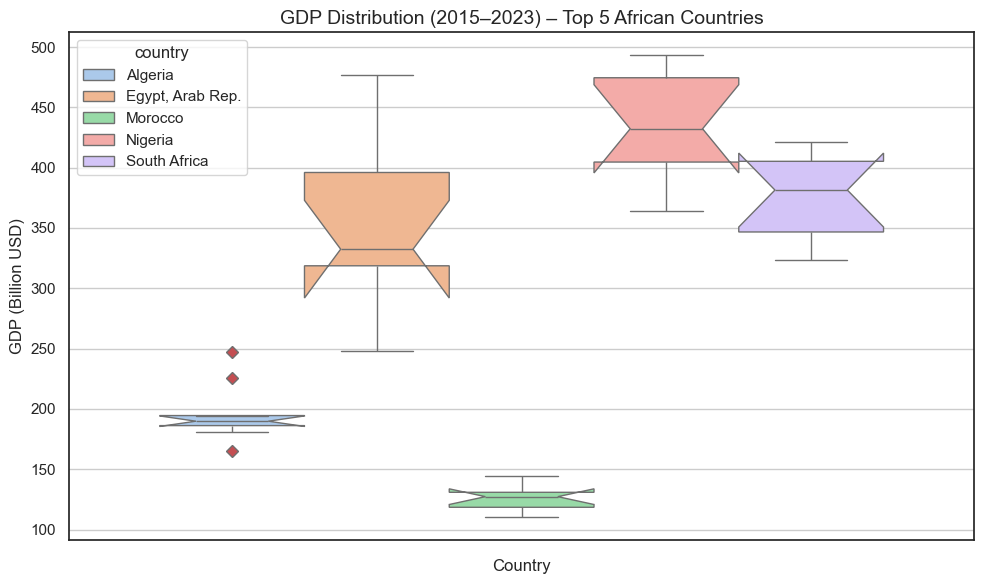

In [68]:
plt.figure(figsize=(10, 6))

flierprops= dict(marker= 'D', markerfacecolor= 'r')

sns.boxplot(data=df_top5, hue="country", y="gdp_usd_billions", palette="pastel", notch= True, flierprops= flierprops)
plt.title("GDP Distribution (2015–2023) – Top 5 African Countries", fontsize=14)
plt.ylabel("GDP (Billion USD)")
plt.xlabel("Country")
plt.grid(axis='y')
#plt.legend(False)
plt.tight_layout()
plt.show()

## QUESTION 2
**creating a dataset from real data on the internet to find the top oil producing countries**

In [69]:

# Create the data as a list of dictionaries
data = [
    {"Rank": 1, "Country": "Nigeria", "Production (bpd)": "1510000"},
    {"Rank": 2, "Country": "Libya", "Production (bpd)": "1400000"},
    {"Rank": 3, "Country": "Angola", "Production (bpd)": "1300000"},
    {"Rank": 4, "Country": "Algeria", "Production (bpd)": "960000"},
    {"Rank": 5, "Country": "Egypt", "Production (bpd)": "700000"},
    {"Rank": 6, "Country": "Equatorial Guinea", "Production (bpd)": "400000"},
    {"Rank": 7, "Country": "Gabon", "Production (bpd)": "300000"},
    {"Rank": 8, "Country": "Republic of the Congo", "Production (bpd)": "267000"},
    {"Rank": 9, "Country": "South Sudan", "Production (bpd)": "200000"},
    {"Rank": 10, "Country": "Ghana", "Production (bpd)": "150000"},
    {"Rank": 11, "Country": "Côte d’Ivoire", "Production (bpd)": "60000"},
    {"Rank": 12, "Country": "Niger", "Production (bpd)": "110000"},
]

# Convert to DataFrame
df_oil_prd = pd.DataFrame(data)

# Save to CSV
#df_oil_prd.to_csv('oil_producing_countries.csv', index=False)


In [70]:
# inspect the data
df_oil_prd.head()

,Rank,Country,Production (bpd)
0,1,Nigeria,1510000
1,2,Libya,1400000
2,3,Angola,1300000
3,4,Algeria,960000
4,5,Egypt,700000


In [71]:
#check the datatypes
df_oil_prd.dtypes

Rank                 int64
Country             object
Production (bpd)    object
dtype: object

In [72]:
# convert the production (bpd) to int
df_oil_prd['Production (bpd)'] = df_oil_prd['Production (bpd)'].astype('Int64')

#create another column to display the numbers for the bpd in millions
df_oil_prd['(bpd) million'] = df_oil_prd['Production (bpd)'] /1e6

In [73]:
#View dataframe
df_oil_prd.head()

,Rank,Country,Production (bpd),(bpd) million
0,1,Nigeria,1510000,1.51
1,2,Libya,1400000,1.4
2,3,Angola,1300000,1.3
3,4,Algeria,960000,0.96
4,5,Egypt,700000,0.7


In [74]:
# View dataframe general information
df_oil_prd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              12 non-null     int64  
 1   Country           12 non-null     object 
 2   Production (bpd)  12 non-null     Int64  
 3   (bpd) million     12 non-null     Float64
dtypes: Float64(1), Int64(1), int64(1), object(1)
memory usage: 540.0+ bytes


In [75]:
# Sort the dataset in descending order
top_oil_prod = df_oil_prd.sort_values('Production (bpd)', ascending=False)
top_oil_prod

,Rank,Country,Production (bpd),(bpd) million
0,1,Nigeria,1510000,1.51
1,2,Libya,1400000,1.4
2,3,Angola,1300000,1.3
3,4,Algeria,960000,0.96
4,5,Egypt,700000,0.7
5,6,Equatorial Guinea,400000,0.4
6,7,Gabon,300000,0.3
7,8,Republic of the Congo,267000,0.267
8,9,South Sudan,200000,0.2
9,10,Ghana,150000,0.15


## Plot the top oil producers

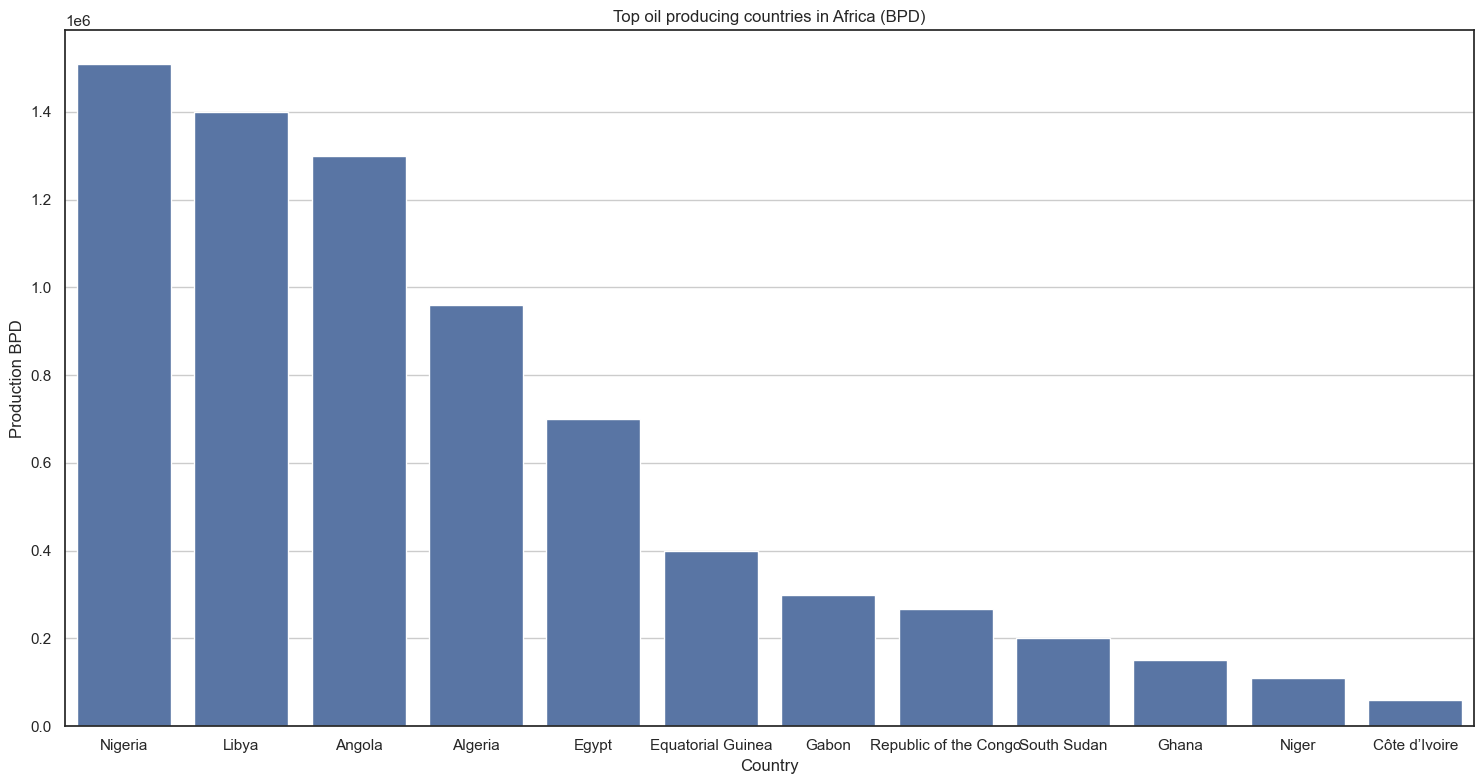

In [120]:
plt.figure(figsize=(15,8))

width= 0.8

sns.barplot(x='Country', y='Production (bpd)', data=top_oil_prod, color='b', width=width)
plt.title('Top oil producing countries in Africa (BPD)')
plt.xlabel('Country')
plt.ylabel('Production BPD')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [118]:
# Manually create the data
data = {
    'Year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'GDP_USD_Billion': [493, 405, 375, 397, 448, 432, 440, 477, 489],
    'Oil_Price (pb)': [52, 43, 54, 71, 64, 41, 70, 99, 82]  # Brent crude avg est.
}

# Create DataFrame
df_nigeria = pd.DataFrame(data)
df_nigeria.head()

,Year,GDP_USD_Billion,Oil_Price (pb)
0,2015,493,52
1,2016,405,43
2,2017,375,54
3,2018,397,71
4,2019,448,64


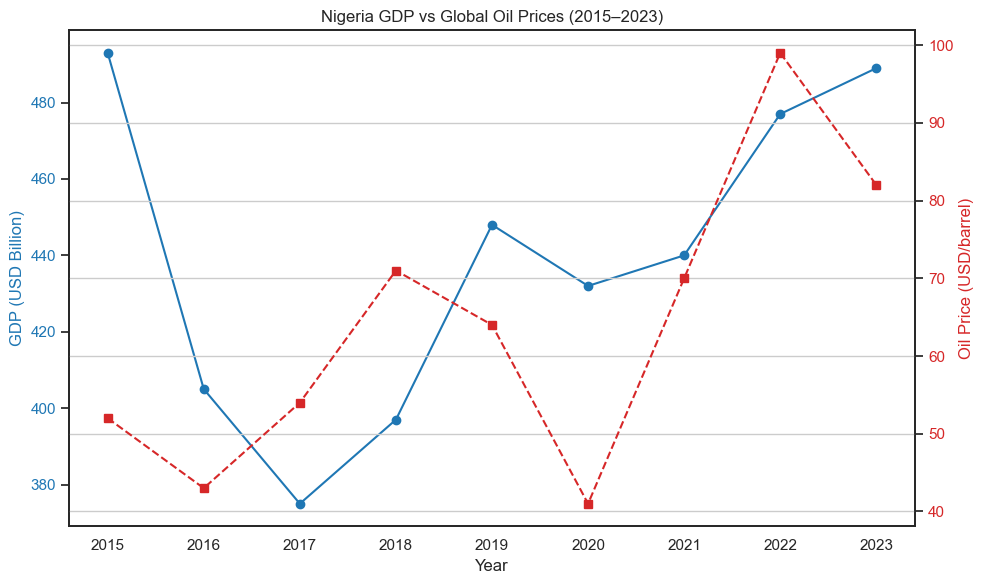

In [119]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# First axis: GDP
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('GDP (USD Billion)', color=color)
ax1.plot(df_nigeria['Year'], df_nigeria['GDP_USD_Billion'], color=color, marker='o', label='Nigeria GDP')
ax1.tick_params(axis='y', labelcolor=color)

# Second axis: Oil Price
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Oil Price (USD/barrel)', color=color)
ax2.plot(df_nigeria['Year'], df_nigeria['Oil_Price (pb)'], color=color, marker='s', linestyle='--', label='Oil_Price (pb)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Nigeria GDP vs Global Oil Prices (2015–2023)')
fig.tight_layout()
plt.grid(True)
plt.show()

In [90]:
# Strip whitespace and make all country names lowercase for consistency
df_clean['country'] = df_clean['country'].str.strip().str.lower()
df_oil_prd['country'] = df_oil_prd['Country'].str.strip().str.lower()


In [ ]:
# Merge initial GDP dataframe with Oil Production Datframe
df_merged = pd.merge(df_clean, df_oil_prd, on='country', how='inner')
#df_merged.to_csv('Merged_dataframe.csv', index=True)

In [ ]:
# Format column to millions
df_merged['Production (bpd) million'] = df_merged['Production (bpd)'] / 1e6

In [ ]:
#Display dataframe
df_merged

,country,iso3,year,gdp_usd,Rank,Country,Production (bpd),(bpd) million,Production (bpd) million
0,algeria,DZA,2015,1.874939e+11,4,Algeria,960000,0.96,0.96
1,algeria,DZA,2016,1.807638e+11,4,Algeria,960000,0.96,0.96
2,algeria,DZA,2017,1.898809e+11,4,Algeria,960000,0.96,0.96
3,algeria,DZA,2018,1.945545e+11,4,Algeria,960000,0.96,0.96
4,algeria,DZA,2019,1.934597e+11,4,Algeria,960000,0.96,0.96
...,...,...,...,...,...,...,...,...,...
67,nigeria,NGA,2019,4.745175e+11,1,Nigeria,1510000,1.51,1.51
68,nigeria,NGA,2020,4.321989e+11,1,Nigeria,1510000,1.51,1.51
69,nigeria,NGA,2021,4.408336e+11,1,Nigeria,1510000,1.51,1.51
70,nigeria,NGA,2022,4.774034e+11,1,Nigeria,1510000,1.51,1.51


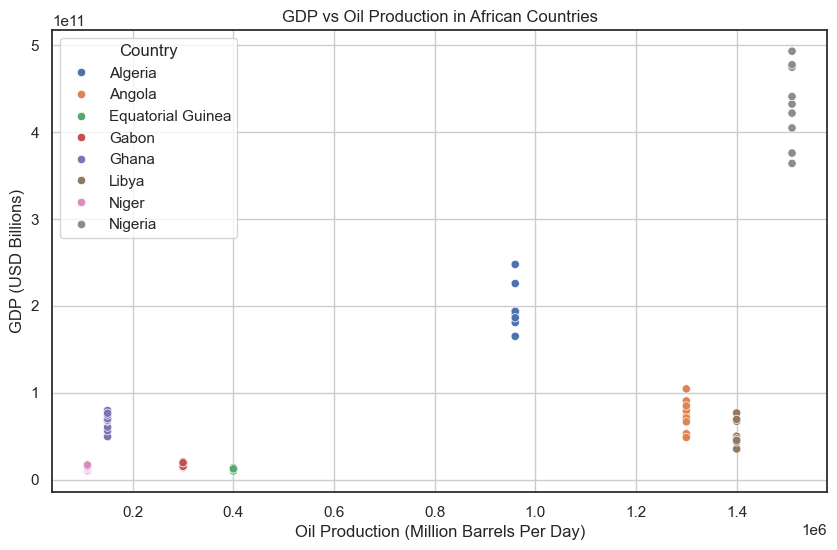

In [ ]:
#plot GDP vs oil production in African countries
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged, x='Production (bpd)', y='gdp_usd', hue='Country')
plt.xlabel("Oil Production (Million Barrels Per Day)")
plt.ylabel("GDP (USD Billions)")
plt.title("GDP vs Oil Production in African Countries")
plt.grid(True)
plt.show()

## Conclusion

**📌 Africa's Economic Giants — 9 years in Review**

Over the last 9 years, Africa has undergone significant economic shifts, with a few standout nations consistently leading the continent in terms of GDP. Our analysis, leveraging World Bank data from 2015 to 2023, reveals a clear pattern: economic leadership in Africa is both diverse in foundation and deeply influenced by resource management, industrial capacity, and geopolitical stability.